In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

In [19]:
def filepath2vec(filepath):
    """
    Loads the frame as a 1-dimensional, grayscale image
    """
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    img_1d = img.flatten()
    height, width = img.shape[:2]
    return img_1d, (width, height)

def show_vec(vec, size):
    """
    Given a 1-dimensional greyscale rep of an image, show it
    """
    width, height = size
    img_2d = vec.reshape((height, width))
    plt.imshow(img_2d, cmap='gray')
    plt.axis('off')
    plt.show()

def folder_to_tensor(folder_path):
    """
    Loads all images from a folder as tensors and concatenates them into a tensor
    """
    image_tensors = []
    
    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)
        if os.path.isfile(filepath):
            (vec, _) = filepath2vec(filepath)
            img_tensor = torch.from_numpy(vec)
            image_tensors.append(img_tensor)
    
    image_tensor = torch.stack(image_tensors)
    return image_tensor

test = folder_to_tensor("frames/i")
print(test)

tensor([[0.1725, 0.1725, 0.1725,  ..., 0.7922, 0.7882, 0.7922],
        [0.1765, 0.1765, 0.1765,  ..., 0.7882, 0.7922, 0.8157],
        [0.1490, 0.1490, 0.1529,  ..., 0.7961, 0.7922, 0.7843],
        [0.1647, 0.1647, 0.1647,  ..., 0.8039, 0.8039, 0.7922],
        [0.1608, 0.1608, 0.1608,  ..., 0.8078, 0.7922, 0.8039],
        [0.1569, 0.1569, 0.1608,  ..., 0.7843, 0.7804, 0.7804]])


In [24]:
class DictionaryLearning(torch.nn.Module):
    def __init__(self, example_path, n_terms):
        super(DictionaryLearning, self).__init__()
        (vec, size) = filepath2vec(example_path) 
        self.dim = len(vec)
        self.size = size
        self.n_terms = n_terms
        self.attributor = self.build_attributor()
        self.dictionary = torch.nn.Parameter(torch.rand((n_terms, self.dim),
            dtype=torch.float,
            requires_grad=True
        ))
    
    def build_attributor(self):
        layers = torch.nn.ModuleList()
        layers.append(torch.nn.Linear(self.dim, self.n_terms))
        layers.append(torch.nn.Softmax())
        return torch.nn.Sequential(*layers)
    
    def forward(self, x):
        return self.attributor(x)
    
    def loss(self, x, attributions):
        reconstruct = torch.matmul(attributions, self.dictionary)
        return torch.nn.MSELoss()(x, reconstruct)

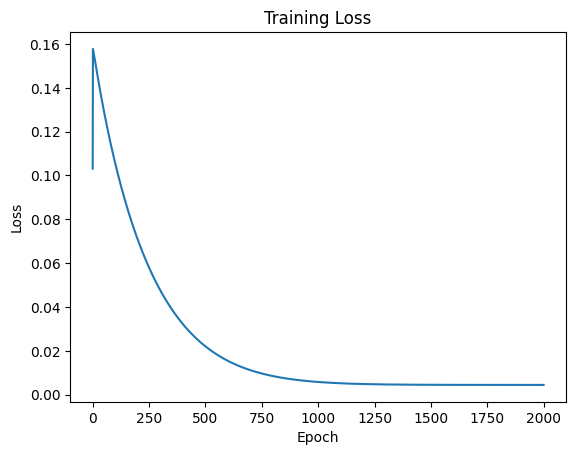

In [32]:
epochs = 600
n_terms = 3
example_filepath = "frames/i/frame_0.png"
model = DictionaryLearning(example_filepath, n_terms)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
data = folder_to_tensor("frames/i")

losses = []

for e in range(epochs):
    attributions = model(data)
    loss = model.loss(data, attributions)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

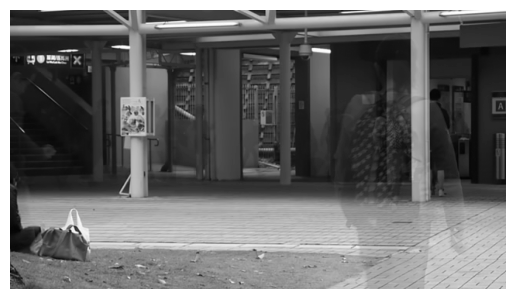

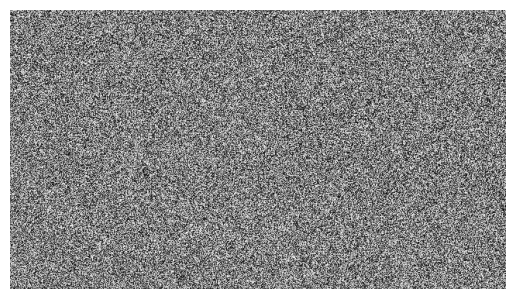

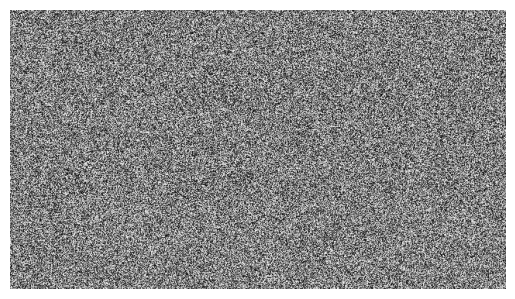

In [33]:
def visualize_basis(model):
    """
    Visualizes all basis elements (vectors) in the model's dictionary
    """
    for i in range(model.n_terms):
        basis_vector = model.dictionary[i].detach().numpy()
        show_vec(basis_vector, model.size)

visualize_basis(model)